# IDAES-GTEP Tutorial Notebook

This notebook presents an introductory tutorial to using the `IDAES-GTEP` tool. To illustrate how to solve an expansion planning model, we use the PJM 5-bus test case with a few different assumptions on the network. With the solution of this model, this tutorial demonstrates some basic result visualizations on the investment options and grid operations. 

To explain the different steps involved in the creation and solution of an expansion planning model, we separated this tutorial into two parts: 

**Part I**: Describes how to create, set up, and solve the `IDAES-GTEP` expansion planning class `ExpansionPlanningModel` using a configuration with time period subsets.

**Part II**: Will describe how to create, set up, and solve the `IDAES-GTEP` expansion planning class `ExpansionPlanningModel` using a configuration with a time period dictionary. NOTE: This part is still work in progress and will be included in a future version of this tutorial. 

## PART I: Create Model with Time Subsets

The expansion planning model `ExpansionPlanningModel` in `IDAES-GTEP` with time period subsets requires the following parameters:

* `stages`: integer number of investment periods

* `formulation`: type of optimal power flow (OPF) problem when using `EGRET`. Currently, this model supports DCOPF and copper plate formulations. Note that this argument is not needed when not using `EGRET`.

* `data`: full set of model data. 

* `num_reps`: integer number of representative periods per investment period.

* `len_reps`: integer length of each representative period in hours.

* `num_commit`: integer number of commitment periods per representative period.

* `num_dispatch`: integer number of dispatch periods per commitment period.


Once we define the parameters, we start building the expansion planning model. We start by importing the necessary libraries from `Pyomo` and `IDAES-GTEP`:

In [1]:
# Import Pyomo components
import pyomo.environ as pyo

# Import expansion planning components from IDAES-GTEP
from gtep.gtep_model import ExpansionPlanningModel
from gtep.gtep_data import ExpansionPlanningData

import pandas as pd

'_BlockData'.  The class '_BlockData' has been renamed to 'BlockData'.
(deprecated in 6.7.2) (called from
C:\Users\blnicho\AppData\Local\anaconda3\Lib\site-
packages\coramin-0.1.1-py3.11.egg\coramin\relaxations\relaxations_base.py:43)
expression symbols from pyomo.core.expr  (deprecated in 6.6.2) (called from
C:\Users\blnicho\AppData\Local\anaconda3\Lib\site-
packages\coramin-0.1.1-py3.11.egg\coramin\domain_reduction\filters.py:4)
Interactive Python mode detected; using default matplotlib backend for plotting.


Include the data for the PJM 5-bus case study and load it to `Prescient`. This loads a default set of representative days.

In [2]:
data_path = "./data/5bus"
data_object = ExpansionPlanningData()
data_object.load_prescient(data_path)

Build the expansion planning object `ExpansionPlanningModel` with no specific OPF formulation. DCOPF is built into the model, so it is the default OPF formulation.

In [3]:
mod_object = ExpansionPlanningModel(
    stages=2,
    data=data_object,
    num_reps=2,
    len_reps=1,
    num_commit=6,
    num_dispatch=4,
)

Create the GTEP model by calling the `create_model` method. 

In [4]:
mod_object.create_model()

[    0.00] Creating GTEP Model
b.year = 2025
Cost data was not provided in m.mc instance (check DataProcessing for more details). Setting costs parameters to random values for now.
b.year = 2030
Cost data was not provided in m.mc instance (check DataProcessing for more details). Setting costs parameters to random values for now.


Apply transformations to convert the GDP problem into a Mixed-Integer Linear Programming (MILP) problem. To do this, first we apply the `bound_pretransformation` from `pyomo.gdp` to define lower and upper bounds that can be used in the Big-M transformation.

In [5]:
pyo.TransformationFactory("gdp.bound_pretransformation").apply_to(mod_object.model)

pyo.TransformationFactory("gdp.bigm").apply_to(mod_object.model)

Declare the solver and solve the problem.

In [6]:
opt = pyo.SolverFactory('highs')
mod_object.results = opt.solve(mod_object.model, tee=True)

Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 24034 rows; 8476 cols; 71866 nonzeros; 4016 integer variables (4012 binary)
Coefficient ranges:
  Matrix [3e-02, 3e+05]
  Cost   [1e+00, 1e+05]
  Bound  [1e+00, 1e+03]
  RHS    [1e+00, 3e+05]
Presolving model
15256 rows, 4394 cols, 46904 nonzeros  0s
10556 rows, 3772 cols, 32800 nonzeros  0s
9961 rows, 2824 cols, 29575 nonzeros  0s

Solving MIP model with:
   9961 rows
   2824 cols (1000 binary, 0 integer, 36 implied int., 1788 continuous, 0 domain fixed)
   29575 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Boun

Process some results into dictionaries.

In [7]:
import pyomo.gdp as gdp
from pyomo.core.base.expression import ScalarExpression, IndexedExpression

valid_names = ["Inst", "Oper", "Disa", "Ext", "Ret"]
renewable_investments = {}
dispatchable_investments = {}
load_shed = {}
for var in mod_object.model.component_objects(pyo.Var, descend_into=True):
    for index in var:
        if "Shed" in var.name:
            if pyo.value(var[index]) >= 0.001:
                load_shed[var.name + "." + str(index)] = pyo.value(var[index])
        for name in valid_names:
            if name in var.name:
                if pyo.value(var[index]) >= 0.001:
                    renewable_investments[var.name + "." + str(index)] = pyo.value(
                        var[index]
                    )
for var in mod_object.model.component_objects(gdp.Disjunct, descend_into=True):
    for index in var:
        for name in valid_names:
            if name in var.name:
                if pyo.value(var[index].indicator_var) == True:
                    dispatchable_investments[var.name + "." + str(index)] = pyo.value(
                        var[index].indicator_var
                    )

costs = {}
for exp in mod_object.model.component_objects(pyo.Expression, descend_into=True):
    if "Cost" in exp.name or "cost" in exp.name:
        if type(exp) is ScalarExpression:
            costs[exp.name] = pyo.value(exp)
        if type(exp) is IndexedExpression:
            for e in exp:
                costs[exp[e].name] = pyo.value(exp[e])

Generate some plots.

c:\users\blnicho\research\idaes-gtep\gtep\tutorial_helper_fns.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bins.set_yticklabels([None] + list(states_set))
c:\users\blnicho\research\idaes-gtep\gtep\tutorial_helper_fns.py:199: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  tmp_rect = plt.Rectangle(


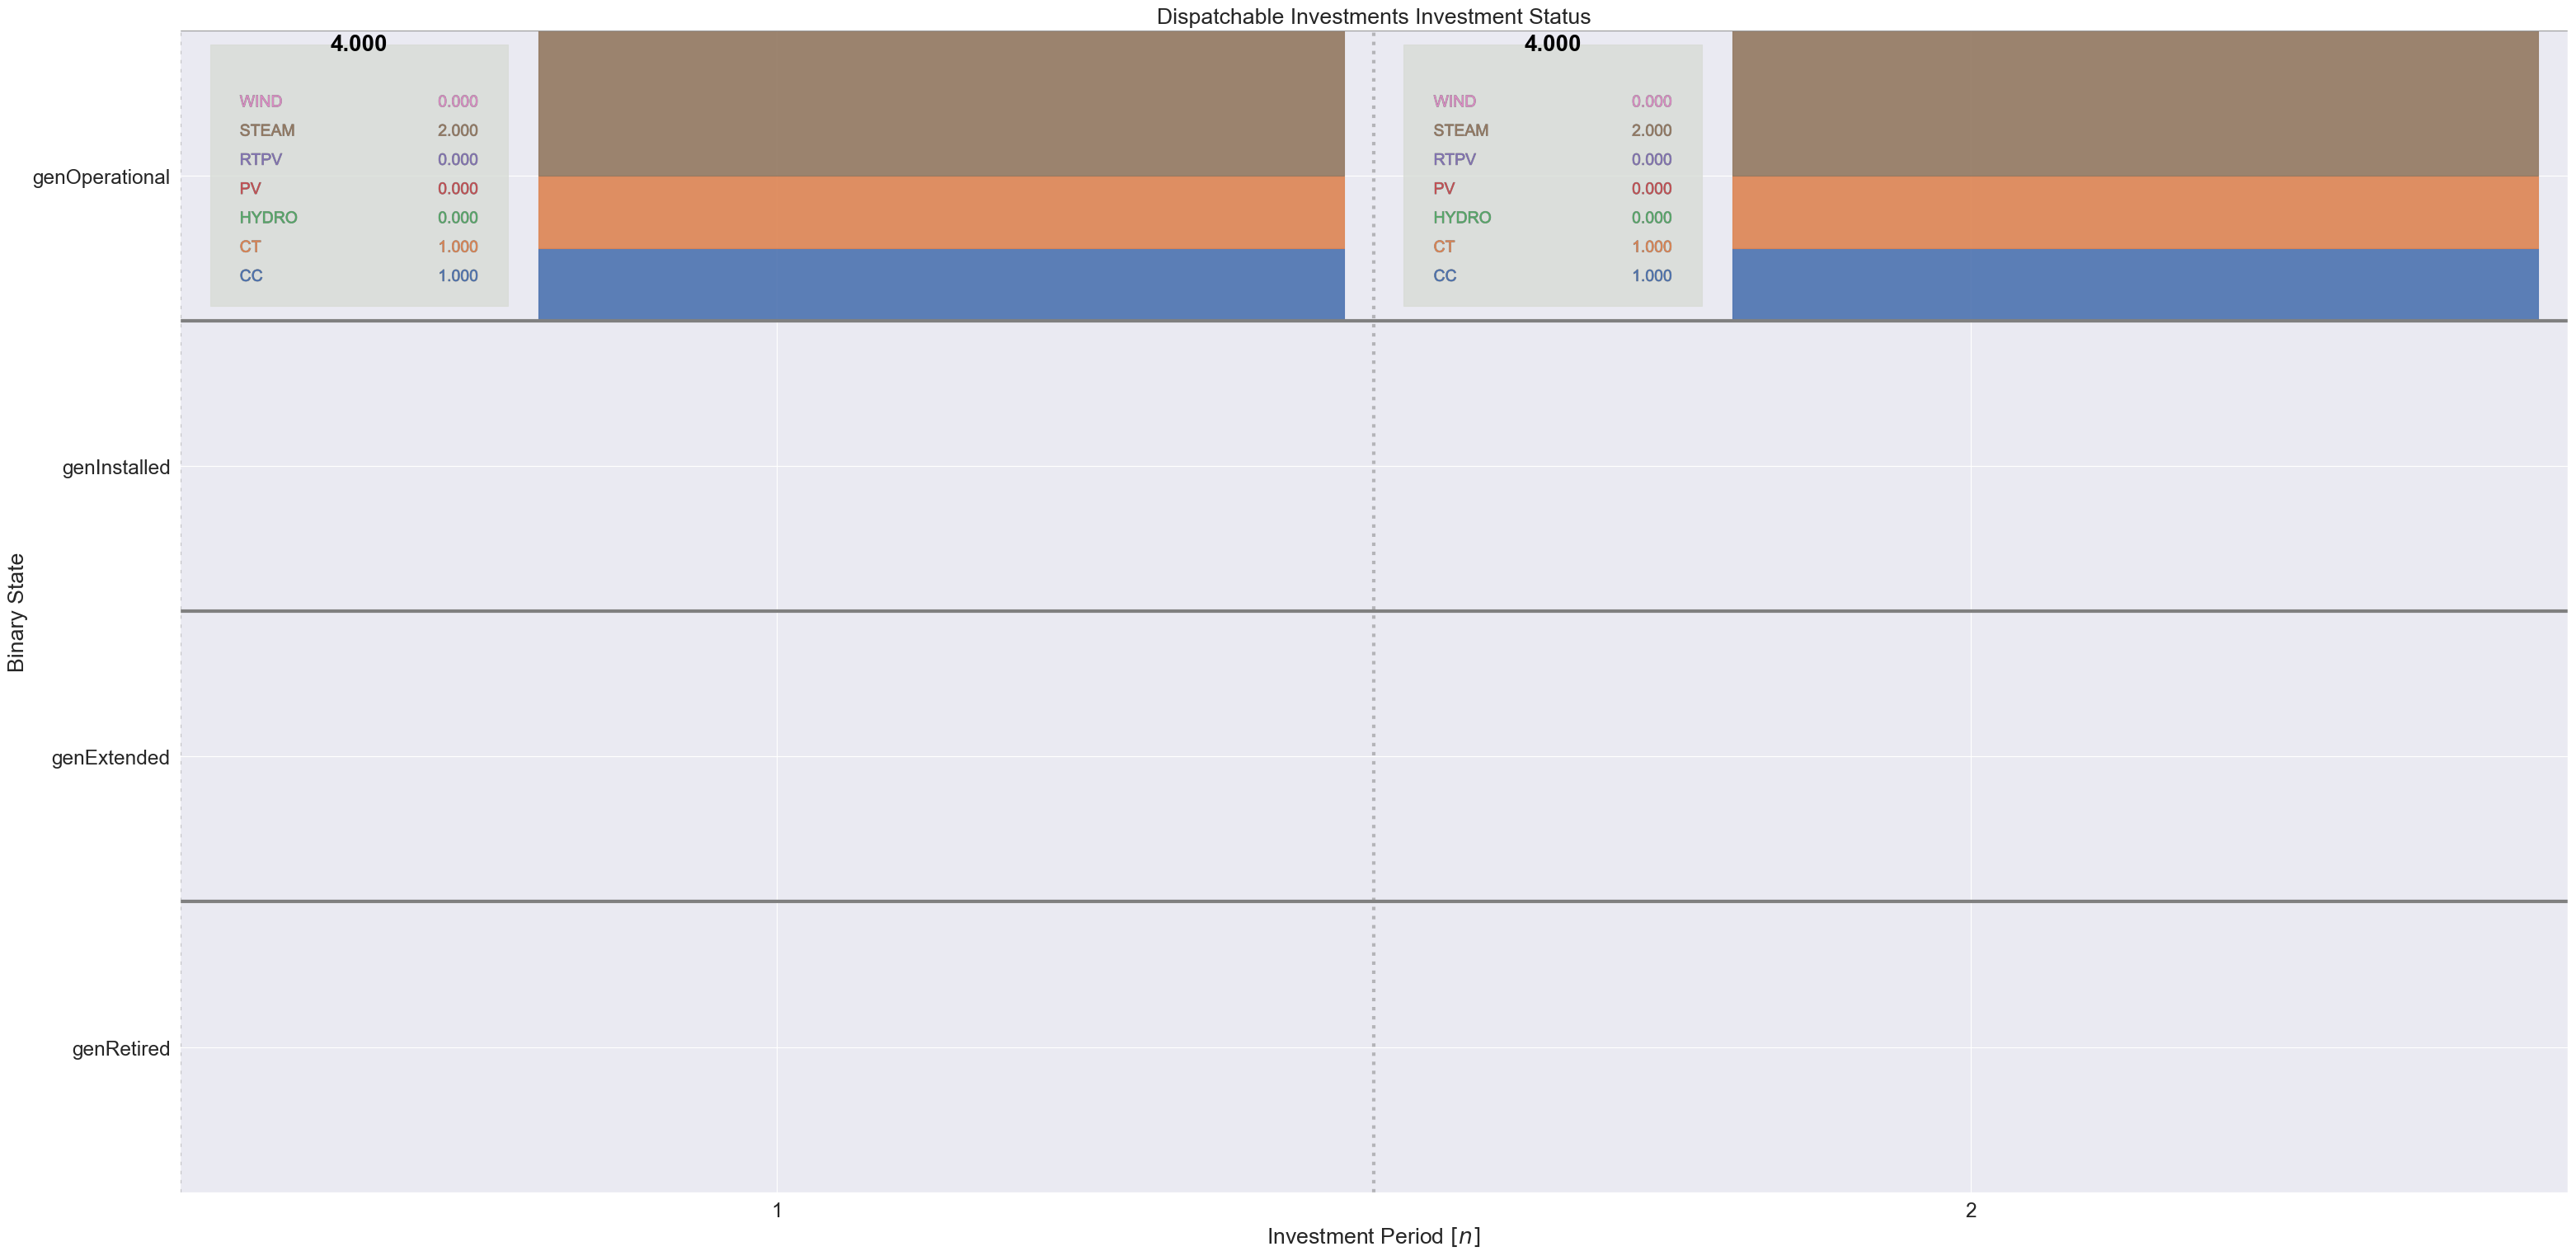

c:\users\blnicho\research\idaes-gtep\gtep\tutorial_helper_fns.py:310: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bins.set_yticklabels([None] + list(states_set))
c:\users\blnicho\research\idaes-gtep\gtep\tutorial_helper_fns.py:415: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  tmp_rect = plt.Rectangle(


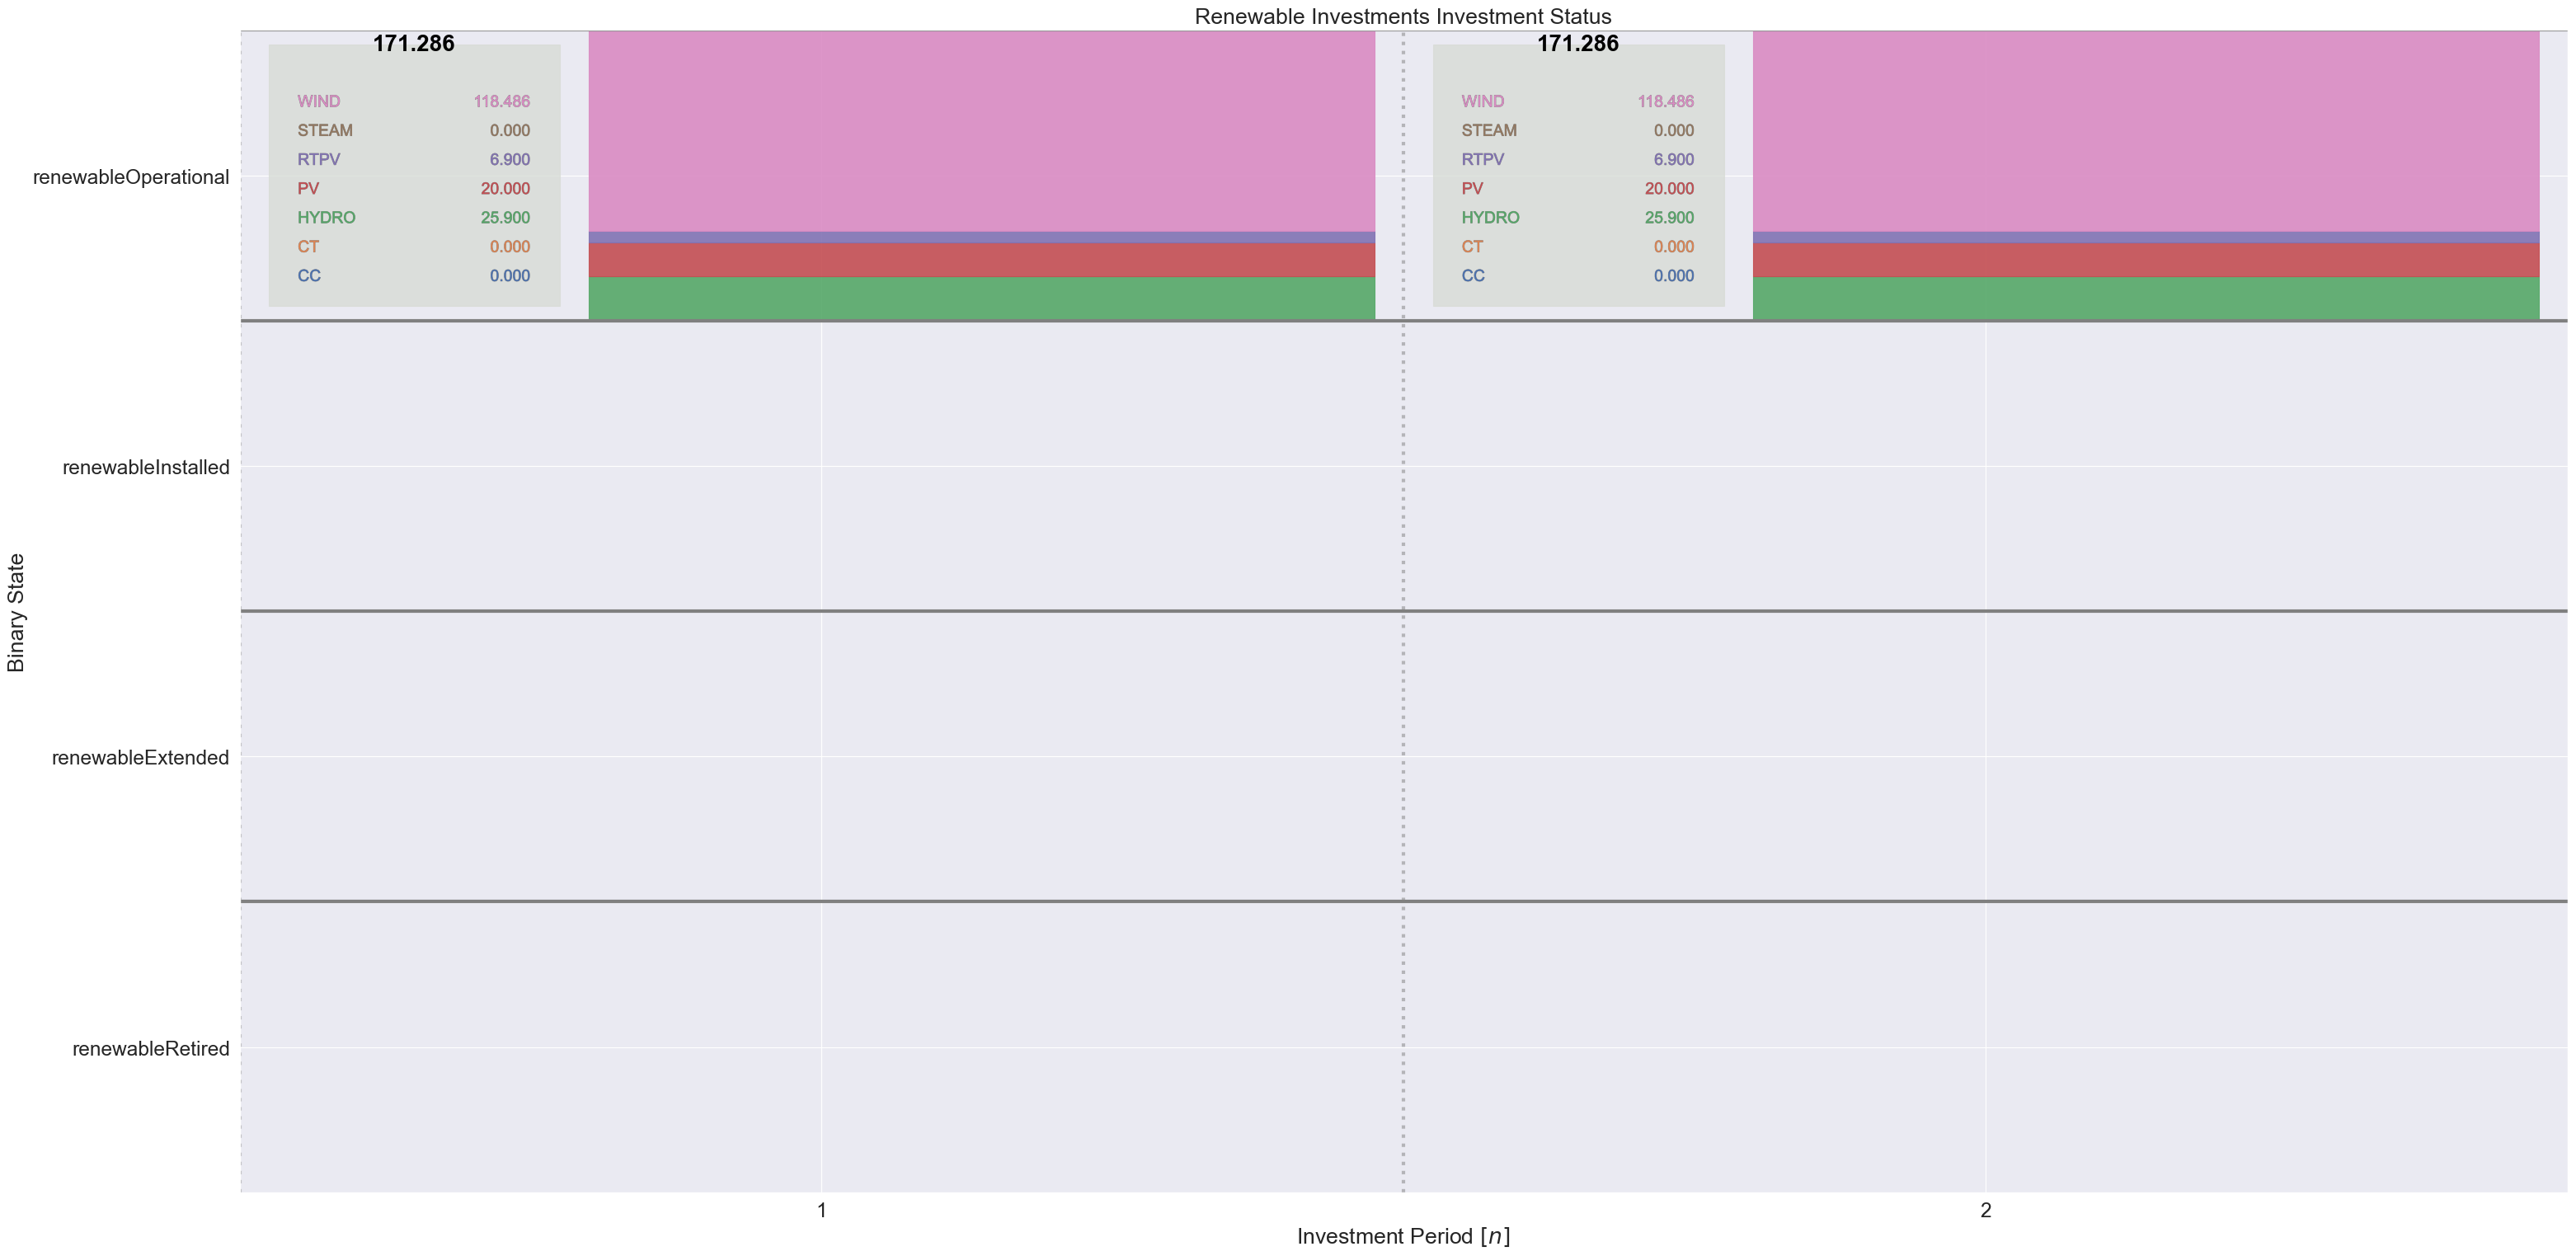

In [8]:
from gtep.tutorial_helper_fns import to_dict, plot_binaries

gens_pd = pd.read_csv("./data/5bus/gen.csv")
this_dict = to_dict(dispatchable_investments)
states_order = ["genRetired", "genExtended", "genInstalled", "genOperational"]
plot_binaries(this_dict, "Dispatchable Investments", states_order, gens_pd)
this_dict = to_dict(renewable_investments)
states_order = [
    "renewableRetired",
    "renewableExtended",
    "renewableInstalled",
    "renewableOperational",
]
plot_binaries(this_dict, "Renewable Investments", states_order, gens_pd)